# Achieving Human Level Competitive Robot Table Tennis

* [Achieving Human Level Competitive Robot Table Tennis](https://deepmind.google/research/publications/107741/)
* [Videos of the matches](https://sites.google.com/view/competitive-robot-table-tennis)

[![Open In
Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google-deepmind/competitive_robot_table_tennis/blob/main/ball_states_viz.ipynb) provides tools to visualize and replay the ball trajectories from the [Achieving Human Level Competitive Robot Table Tennis](https://deepmind.google/research/publications/107741/) paper. It utilizes a Mujoco model incorporating a fluid dynamics simulation and realistic table tennis interactions. For optimal visualization, a GPU connection is recommended.



In [ ]:
#@title Import dependencies

!pip install mujoco

# Set up GPU rendering.
import os
import subprocess
import dataclasses
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco as mj
  from mujoco import rollout
  mj.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt
import pandas as pd

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()


In [ ]:
#@title Heplers and resources


# System identified Table Tennis Table and Ball contacts.
pp_ball_with_table_xml = """
<mujoco model="pp_ball_with_table">
  <compiler angle="radian" autolimits="true"/>
  <option density="1.225" viscosity="1.8e-5" wind="0 0 0" integrator="implicitfast" timestep="0.001" cone="elliptic"/>

  <visual>
    <headlight diffuse=".5 .5 .5" specular="1 1 1"/>
  </visual>

  <asset>
    <texture type="skybox" builtin="gradient" rgb1=".5 .5 .5" rgb2="0 0 0" width="10" height="10"/>
    <texture type="2d" name="groundplane" builtin="checker" mark="edge" rgb1="1 1 1" rgb2="1 1 1" markrgb="0 0 0" width="300" height="300"/>
    <material name="groundplane" texture="groundplane" texuniform="true" texrepeat="5 5" reflectance="0.3"/>
  </asset>

  <worldbody>
    <light pos="0 0 3" diffuse="1 1 1" specular="1 1 1"/>

    <body name="ball" pos="0.0 -0.5 0.652">
      <inertial pos="0 0 0" mass="2.7e-3" diaginertia="0.00000072 0.00000072 0.00000072"/>
      <freejoint/>
      <geom name="geom_ball" size=".02" shellinertia="false" fluidcoef="0.235 0.25 0.0 1.0 1.0" group="1" rgba="0.98 0.70 0.015 1" solref="-100000 -0" fluidshape="ellipsoid"/>
    </body>

    <body name="table" pos="0 0 -0.76" quat="0.7071068 0 0 0.7071068">
      <geom name="geom_table" size="1.37 0.7625 0.02" pos="0 0 0.74" type="box" rgba="0.27 0.51 0.14 1"/>
      <geom size="0.005 0.915 0.07625" pos="0 0 0.83625" type="box" rgba="1 1 1 0.5"/>
      <geom size="1.371 0.7635 0.02" pos="0 0 0.739" type="box" contype="0" conaffinity="0" group="1" density="0" rgba="0 0 0 1"/>
    </body>

  </worldbody>

  <contact>
      <pair geom1="geom_ball" geom2="geom_table" solref="-1000000 -17" friction="0.1 0.1 0.005 0.0001 0.0001" solimp="0.98 0.99 0.001 0.5 2" solreffriction="-0.0 -200.0"/>
  </contact>

</mujoco>
"""


@dataclasses.dataclass
class BallState:
  """Initial ball state."""
  id: int
  pos_x: float
  pos_y: float
  pos_z: float
  vel_x: float
  vel_y: float
  vel_z: float
  w_vel_x: float
  w_vel_y: float
  w_vel_z: float

  @property
  def position(self) -> np.ndarray:
    return np.array([self.pos_x, self.pos_y, self.pos_z])

  @property
  def linear_velocity(self) -> np.ndarray:
    return np.array([self.vel_x, self.vel_y, self.vel_z])

  @property
  def angular_velocity(self) -> np.ndarray:
    return np.array([self.w_vel_x, self.w_vel_y, self.w_vel_z])


def rollout_and_render(
            ball_state: BallState,
            model: mj.MjModel,
            data: mj.MjData,
            duration: float = 1.0,
            framerate: int = 30):

  scene_option = mj.MjvOption()
  scene_option.flags[mj.mjtVisFlag.mjVIS_CONTACTPOINT] = True

  frames = []
  with mj.Renderer(model, 480, 640) as renderer:
    mj.mj_resetData(model, data)
    data.qpos[:3] = ball_state.position[:]
    data.qvel[:3] = ball_state.linear_velocity[:]
    data.qvel[3:] = ball_state.angular_velocity[:]
    mj.mj_forward(model, data)
    print("qpos:", data.qpos)
    print("qvel:", data.qvel)
    while data.time < duration:
      mj.mj_step(model, data)
      if len(frames) < data.time * framerate:
        renderer.update_scene(data, scene_option=scene_option)
        pixels = renderer.render()
        frames.append(pixels)

  media.show_video(frames, fps=framerate)

In [ ]:
#@title Datasets

!wget https://raw.githubusercontent.com/google-deepmind/competitive_robot_table_tennis/refs/heads/main/rallies.json
!wget https://raw.githubusercontent.com/google-deepmind/competitive_robot_table_tennis/refs/heads/main/serves.json
!ls

In [ ]:
rallies_pd = pd.read_json("rallies.json")
serves_pd = pd.read_json("serves.json")


# rallies and serves contain all the ball states.
rallies = rallies_pd.apply(lambda row: BallState(*row), axis=1)
serves = serves_pd.apply(lambda row: BallState(*row), axis=1)

print(f"rallies={len(rallies)=}, serves={len(serves)}")

rallies=len(rallies)=14119, serves=3365


In [ ]:
#@title Visualize random rallying and serving ball states

random_rallies = rallies.sample(n=3, random_state=42)
random_serves = serves.sample(n=3, random_state=42)


model = mj.MjModel.from_xml_string(pp_ball_with_table_xml)
data = mj.MjData(model)

# rallies
for ball_state in random_rallies:
  rollout_and_render(ball_state, model, data)

# serves
for ball_state in random_serves:
  rollout_and_render(ball_state, model, data)

qpos: [0.059 0.962 0.304 1.    0.    0.    0.   ]
qvel: [  0.537  -5.702   0.536 -21.413   6.38    3.019]


qpos: [-0.35  1.23  0.54  1.    0.    0.    0.  ]
qvel: [  1.62  -5.77   1.05  68.88 -11.57 -19.28]


qpos: [-0.133  1.547  0.385  1.     0.     0.     0.   ]
qvel: [  1.044  -5.174   2.37   61.202 -14.809 -47.192]


qpos: [0.155 1.482 0.121 1.    0.    0.    0.   ]
qvel: [ 0.829 -5.701 -2.475 12.874 16.467 -5.126]


qpos: [-0.278  1.373  0.498  1.     0.     0.     0.   ]
qvel: [-0.498 -3.709 -0.612  0.488 -0.679 -5.636]


qpos: [-0.299  1.339  0.47   1.     0.     0.     0.   ]
qvel: [  0.811  -3.287  -1.854 -25.12  -20.055  24.215]


#Using Mujoco `rollout` for fast rollout

See [rollout.ipynb](https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/rollout.ipynb) for more exciting new features.

In [ ]:
def get_state(model: mj.MjModel, data: mj.MjData, nbatch:int = 1):
  full_physics = mj.mjtState.mjSTATE_FULLPHYSICS
  state = np.zeros((mj.mj_stateSize(model, full_physics),))
  mj.mj_getState(model, data, state, full_physics)
  return np.tile(state, (nbatch, 1))


def init_rollout(ball_state: BallState, model: mj.MjModel, data: mj.MjData):
  mj.mj_resetData(model, data)
  data.qpos[:3] = ball_state.position[:]
  data.qvel[:3] = ball_state.linear_velocity[:]
  data.qvel[3:] = ball_state.angular_velocity[:]
  mj.mj_forward(model, data)


ball_trajectory (1, 699, 14)
ball_trajectory (1, 699, 14)
ball_trajectory (1, 699, 14)
ball_trajectory (1, 699, 14)
ball_trajectory (1, 699, 14)
ball_trajectory (1, 699, 14)


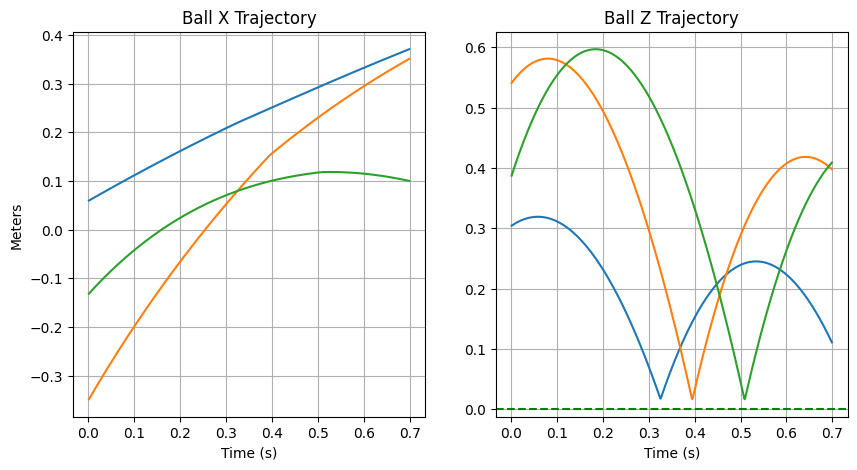

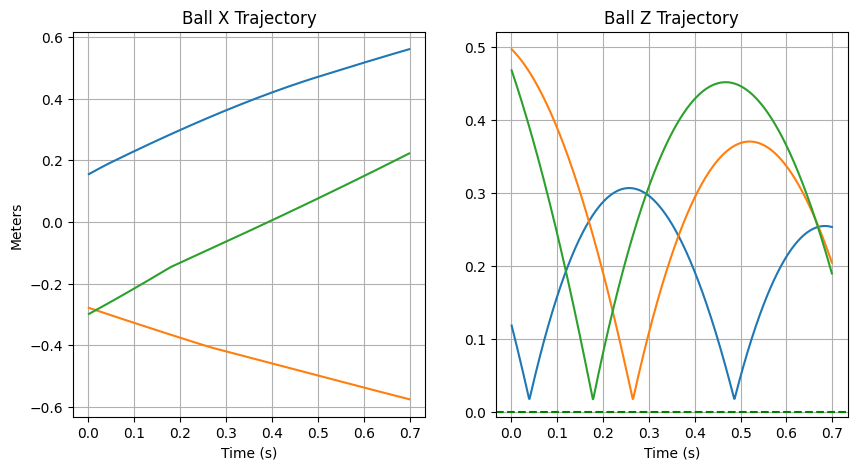

In [ ]:
#@title Visualize Trajectories

def trajectories(ball_states, duration_s=1.0):
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))
  for ball_state in ball_states:
    init_rollout(ball_state, model, data)
    mj_state = get_state(model, data)

    nstep = int(duration_s / model.opt.timestep)
    # (batch_size, time, qpos, qvel, ...)
    ball_trajectory, _ = rollout.rollout(model, data, mj_state, nstep=nstep)
    print("ball_trajectory", ball_trajectory.shape)

    timesteps = ball_trajectory[0, :, 0]
    x_value = ball_trajectory[0, :, 1]
    z_value = ball_trajectory[0, :, 3]

    ax[0].plot(timesteps, x_value)
    ax[1].plot(timesteps, z_value)

  plt.axhline(0.0, color ="green", linestyle ="--")
  ax[0].set_title("Ball X Trajectory")
  ax[1].set_title("Ball Z Trajectory")
  ax[0].set_xlabel("Time (s)")
  ax[1].set_xlabel("Time (s)")
  ax[0].set_ylabel("Meters")
  ax[0].grid()
  ax[1].grid()

trajectories(random_rallies, duration_s=0.7)
trajectories(random_serves, duration_s=0.7)